# DataSet Performance

This notebook shows the tradeoffs between inserting data into the database row by row and as binary blobs.
There is a tradeoff between inserting the data in these to ways. 


Inserting the data row by row means that we direct access to all the data and may perform querys directly on the values of the data. On the other hand as we will see below this is much slower than inserting the data direcly as binary blobs

In [44]:
%matplotlib notebook
from collections import OrderedDict
from typing import Dict, Callable
from inspect import signature
import numpy.random as rd
import matplotlib.pyplot as plt
import json
from functools import partial
import numpy as np

from time import sleep, monotonic

import qcodes as qc
from qcodes import Station
from qcodes.instrument.parameter import ManualParameter
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.param_spec import ParamSpec
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_export import get_shaped_data_by_runid
import time
# import logging
# logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')


In [45]:
initialise_database()
new_experiment(name='tutorial_exp', sample_name="no sample")

tutorial_exp#no sample#6@c:\Users\jenielse\mymainfolder\experiments.db
----------------------------------------------------------------------

Here we define a simple function to benchmark the time it takes to insert n points with either numeric or array data type

In [46]:
def insert_data(paramtype, npoints):

    meas = Measurement()

    x1 = ManualParameter('x1')
    x2 = ManualParameter('x2')
    x3 = ManualParameter('x3')
    y1 = ManualParameter('y1')
    y2 = ManualParameter('y2')

    meas.register_parameter(x1, paramtype=paramtype)
    meas.register_parameter(x2, paramtype=paramtype)
    meas.register_parameter(x3, paramtype=paramtype)
    meas.register_parameter(y1, setpoints=[x1, x2, x3],
                            paramtype=paramtype)
    meas.register_parameter(y2, setpoints=[x1, x2, x3],
                            paramtype=paramtype)

    with meas.run() as datasaver:
        start = time.perf_counter()
        datasaver.add_result((x1, np.random.rand(npoints)),
                             (x2, np.random.rand(npoints)),
                             (x3, np.random.rand(npoints)),
                             (y1, np.random.rand(npoints)),
                             (y2, np.random.rand(npoints)))
        stop = time.perf_counter()
        tottime = stop - start
        print(f"Inserting npoints {npoints} of data took {tottime}")
        return tottime

And perform a quick comparison of the two 

In [49]:
sizes = [1,10,100]
t_numeric = []
t_array = []
for size in sizes:
    t_numeric.append(insert_data('numeric', size))
    t_array.append(insert_data('array', size))
    

Starting experimental run with id: 168
Inserting npoints 1 of data took 0.0001434000000699598
Starting experimental run with id: 169
Inserting npoints 1 of data took 0.00012229999992996454
Starting experimental run with id: 170
Inserting npoints 10 of data took 0.00032929999997577397
Starting experimental run with id: 171
Inserting npoints 10 of data took 0.0001650999997764302
Starting experimental run with id: 172
Inserting npoints 100 of data took 0.005970600000182458
Starting experimental run with id: 173
Inserting npoints 100 of data took 0.0001297999997404986


<IPython.core.display.Javascript object>


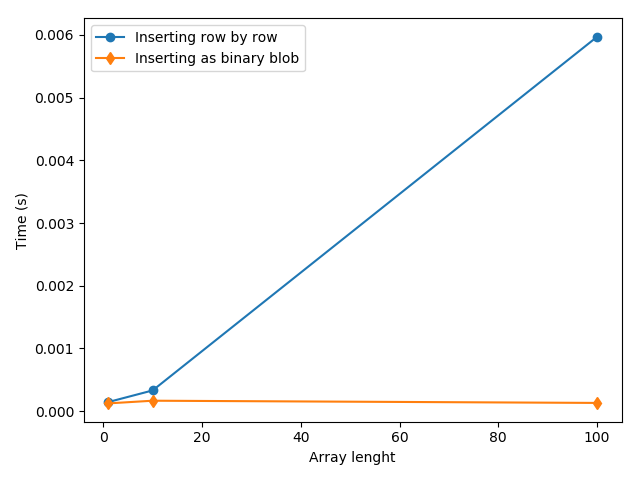

In [50]:
fig, ax = plt.subplots(1,1)
ax.plot(sizes, t_numeric, 'o-', label='Inserting row by row')
ax.plot(sizes, t_array, 'd-', label='Inserting as binary blob')
ax.legend()
ax.set_xlabel('Array lenght')
ax.set_ylabel('Time (s)')
fig.tight_layout()